In [143]:
from thequickmath.reduced_models.models import MoehlisFaisstEckhardtModel, rk4_timestepping

from deeptime.clustering import KMeans, RegularSpace
import deeptime.markov as markov
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math
import time

In [144]:
Re = 500.0
Lx = 1.75 * np.pi
Lz = 1.2 * np.pi

time_step = 0.001
n_steps = 15000000

In [145]:
model = MoehlisFaisstEckhardtModel(Re, Lx, Lz)

In [149]:
#Задание начальных условий, получение траектории

def random_initial_conditions(m_size):
    ic = np.zeros(m_size)
    ic[0] = np.random.uniform(0, 1)
    ic[1:8] = np.random.uniform(-1, 1, size=m_size-2)
    ic[8] = np.random.uniform(-1, 0)
    return ic

def generate_trajectory(model, time_step, n_steps):
    start_time = time.time()
    ic = random_initial_conditions(1, model.dim)
    trajectory = rk4_timestepping(model, ic, time_step, n_steps, time_skip = 1000, debug = False)
    print("%s seconds" % (time.time() - start_time))
    return trajectory[:-1:]

In [139]:
# Вывод графиков

def print_2d(v):
    fig, ax = plt.subplots(1, 1, figsize=(5,3), constrained_layout=True)
   
    p1 = ax.imshow(v, cmap='viridis', aspect='equal', origin="lower")
    ax.set_title("Flow")

    axins = inset_axes(ax,
                   width="7%",
                   height="70%",
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   )
    plt.colorbar(p1, ax=ax, cax=axins, label='Velocity')
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    
def show_flow(trajectory, y, l):
    points = np.arange(0, len(trajectory), len(trajectory)//l)
    d_x = np.arange(0, Lx, 0.05)
    d_z = np.arange(0, Lz, 0.05)
    field_y0 = np.zeros((len(points), len(d_z), len(d_x)))
    for i in range(len(points)):
        for x in range(len(d_x)):
            for z in range(len(d_z)):
                field_y0[i][z][x] = model.three_dim_flow_field(trajectory[points[i]], d_x[x], y, d_z[z])
    return field_y0

def show_energy(trajectory, label):
#     plt.figure(figsize=(10,3))
    ek = model.kinetic_energy(trajectory)
#     plt.plot(np.arange(len(trajectory)-1), ek, 'o-', markersize=1.)
    if label:
        plt.plot(np.arange(len(trajectory)), ek, linewidth=0.7, color = label, markersize = 0.5)
    else:
        plt.plot(np.arange(len(trajectory)), ek,  linewidth=1, markersize = 0.5)
#     plt.plot(14956, ek[14956], 'o')
    plt.xlabel("$t$")
    plt.ylabel("$E$")
#     plt.title(label)
#     plt.grid()
#     plt.show()
    return ek

In [38]:
# tr = generate_trajectory(model, time_step, n_steps)

In [39]:
# ek = show_energy(tr[1:], 'Trajectory')

In [40]:
# Генерируем траекторию Т=15000

# trajectory = generate_trajectory(model, time_step, n_steps)
# np.savetxt('trajectory_for_clustering.txt', trajectory)

In [41]:
# tr_test1 = generate_trajectory(model, time_step, n_steps)
# np.savetxt('trajectory_test1.txt', tr_test1)

In [10]:
# tr_test2 = generate_trajectory(model, time_step, n_steps)
# np.savetxt('trajectory_test2.txt', tr_test2)

In [6]:
# Загружаем траектории

trajectory = np.loadtxt('trajectory_for_clustering.txt')
tr_test1 = np.loadtxt('trajectory_test1.txt')
tr_test2 = np.loadtxt('trajectory_test2.txt')

In [7]:
# Кластеризация

def states_clustering(method, n_iter_max = 1000, n_cl = 500, dist = 3): 
    if method == 'kmeans_uniform':
        init_c = 'uniform'
    else:
        init_c = 'kmeans++'

    estimator = KMeans(
        n_clusters = n_cl,  
        init_strategy = init_c,  
        max_iter = n_iter_max,  
        fixed_seed=13,
        n_jobs=8)
    start_time = time.time()
    clustering = estimator.fit(trajectory).fetch_model()
    assignments = clustering.transform(trajectory)
    print("%s seconds" % (time.time() - start_time))
    return clustering, assignments

def show_energy_clustering(clustering, assignments, label):
    tr_cl = np.zeros((len(assignments), model.dim))
    for i in range(len(assignments)):
        if assignments[i] == -1:
            tr_cl[i] = tr_cl[i-1] 
        else:
            tr_cl[i] = clustering.cluster_centers[assignments[i]] 
    return show_energy(tr_cl, label)

def show_inertia(clust1, clust2):
    plt.figure(figsize = (5,3))
    plt.loglog(clust1.inertias, label='cl1')
    plt.loglog(clust2.inertias, label='cl2')
    plt.grid()
    plt.legend()
    plt.xlabel("iteration")
    plt.ylabel("inertia")

In [8]:
clust_ku_1, assign_ku_1 = states_clustering('kmeans_uniform', n_iter_max = 1000, n_cl = 1000)
clust_kk_1, assign_kk_1 = states_clustering('kmeans_k++', n_iter_max = 1000, n_cl = 1000)
# clust_rs, assign_rs = states_clustering('regular_space', 1000, 500, 0.01)

0.9118564128875732 seconds
1.3104650974273682 seconds


In [95]:
clust_ku_1.get_params()


{'cluster_centers': array([[ 1.28096372e-01,  8.60405278e-02, -4.97240527e-02, ...,
          3.88422859e-02, -1.77570932e-02, -1.48651856e-01],
        [ 9.99999999e-01, -2.20560858e-19,  2.59734790e-22, ...,
          8.28994103e-27, -2.46677484e-27, -3.42591600e-39],
        [ 1.15418045e-01,  5.74596699e-02, -3.22021786e-02, ...,
          1.45738404e-01,  2.70506677e-02, -7.38660349e-02],
        ...,
        [ 1.52359657e-01,  1.94784753e-03,  6.55984594e-02, ...,
          3.01903446e-02,  1.89848264e-02, -8.39938376e-02],
        [ 8.89311348e-01, -4.49142351e-03,  5.43441789e-05, ...,
          3.17736068e-03, -4.52336404e-05, -2.44040241e-05],
        [ 9.99998994e-01, -1.19818205e-12,  1.44527604e-15, ...,
         -2.56535234e-17, -6.56712534e-19, -1.03560236e-25]]),
 'metric': 'euclidean',
 'tolerance': 1e-05,
 'inertias': array([44.28557292, 36.90561199, 33.1711563 , 30.49876465, 29.18284455,
        28.24371387, 27.67081257, 27.26309839, 27.12369299, 27.01327882,
       

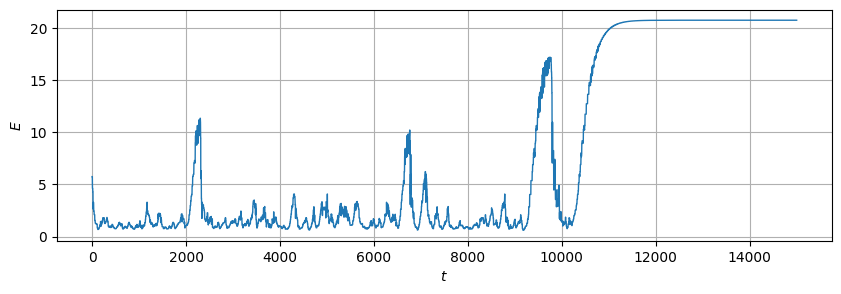

In [47]:
# ek = show_energy(trajectory, 'Trajectory')
# ek_ku = show_energy_clustering(clust_ku_1, assign_ku_1, 'KMeans uniform, 1000 cl')
plt.figure(figsize=(10,3))
# ek = show_energy(trajectory, '')
ek_ku = show_energy_clustering(clust_ku_1, assign_ku_1, '')
plt.grid()
plt.show()
# show_inertia(clust_ku_1, clust_kk_1)

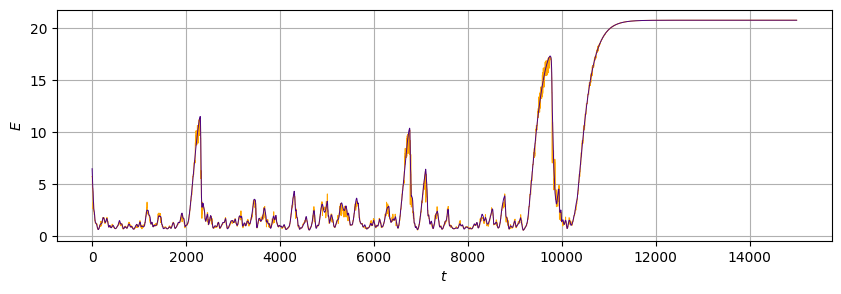

In [48]:
plt.figure(figsize=(10,3))
ek_ku1_t1 = show_energy_clustering(clust_ku_1, assign_ku_1, 'orange')
ek_t1 = show_energy(trajectory, '#4B0082')
plt.grid()
plt.show()

In [154]:
ek_ku[12000]

20.719773123571674

In [15]:
# sum(abs(trajectory[1] - trajectory[2]))

In [16]:
# len(assign_kk_1)

1.2403953075408936 seconds
0.9476809501647949 seconds
1.2427406311035156 seconds
1.4005095958709717 seconds
1.3978495597839355 seconds
1.2065632343292236 seconds
0.877875566482544 seconds
1.061767339706421 seconds
1.3989291191101074 seconds
1.5846846103668213 seconds
1.2236592769622803 seconds
1.100437879562378 seconds
1.2493860721588135 seconds
1.1028246879577637 seconds
2.634634256362915 seconds
2.0801591873168945 seconds
1.6712253093719482 seconds
1.5867104530334473 seconds
1.9287238121032715 seconds
2.3839240074157715 seconds


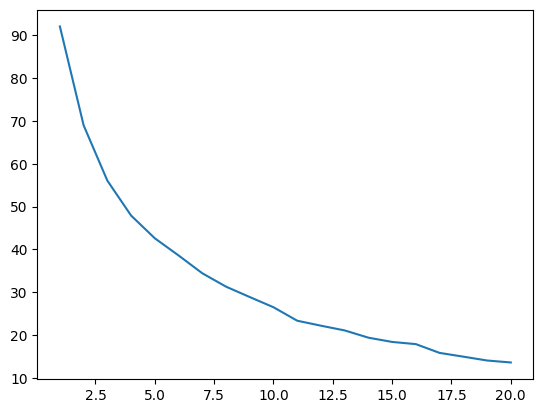

In [27]:
# nit = 20
# err = np.zeros(nit)

# for i in range(nit):
#     clust, assign = states_clustering('kmeans_uniform', n_iter_max = 1000, n_cl = (i+1)*100)
#     clust.cluster_centers[assign[1]]
#     for j in range(len(assign)):
#         err[i] += sum((clust.cluster_centers[assign[j]] - trajectory[j])**2)
        
# plt.plot(np.arange(1, nit+1), err)
# plt.show()

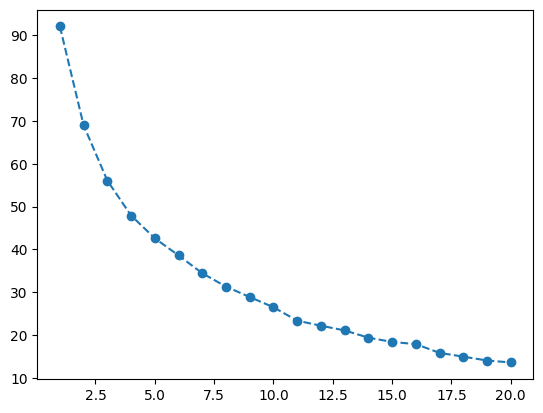

In [28]:
plt.plot(np.arange(1, nit+1), err, 'o--')
plt.show()

ValueError: 'KMeans++, 1000 cl' is not a valid value for color

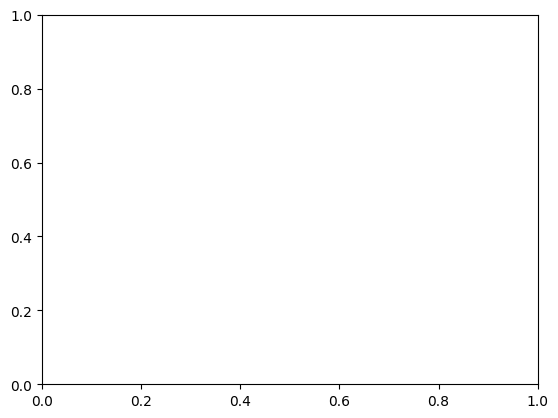

In [25]:
ek_kk = show_energy_clustering(clust_kk_1, assign_kk_1, 'KMeans++, 1000 cl')

In [ ]:
# clust_ku, assign_ku = states_clustering('kmeans_uniform', 1000, 1500)
# clust_kk, assign_kk = states_clustering('kmeans_k++', 1000, 1500)

In [47]:
# ek = show_energy(trajectory, 'Trajectory')
# ek_ku = show_energy_clustering(clust_ku, assign_ku, 'KMeans uniform, 1500 it')
# ek_kk = show_energy_clustering(clust_kk, assign_kk, 'KMeans++, 1500 it')
# show_inertia(clust_ku, clust_kk)

In [26]:
assign_test1_ku1 = clust_ku_1.transform(tr_test1)
# assign_test1_kk1 = clust_kk_1.transform(tr_test1)
# assign_test1_ku = clust_ku.transform(tr_test1)
# assign_test1_kk = clust_kk.transform(tr_test1)

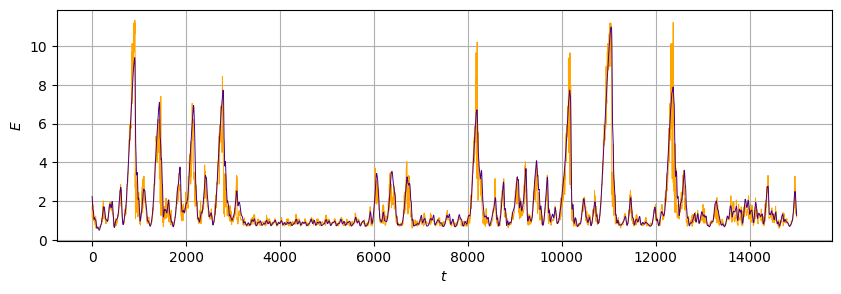

In [49]:
# ek_t1 = show_energy(tr_test1, 'Test1')
# ek_ku1_t1 = show_energy_clustering(clust_ku_1, assign_test1_ku1, 'Test1: KMeans uniform, 1000 cl')
# ek_kk1_t1 = show_energy_clustering(clust_kk_1, assign_test1_kk1, 'Test1: KMeans++, 1000 it')
# ek_ku_t1 = show_energy_clustering(clust_ku, assign_test1_ku, 'Test1: KMeans uniform, 1500 it')
# ek_kk_t1 = show_energy_clustering(clust_kk, assign_test1_kk, 'Test1: KMeans++, 1500 it')

plt.figure(figsize=(10,3))

ek_ku1_t1 = show_energy_clustering(clust_ku_1, assign_test1_ku1, 'orange')
ek_t1 = show_energy(tr_test1, '#4B0082')
plt.grid()
plt.show()

In [96]:
len(tr_test1)

15000

In [28]:
# mse = 0

# for j in range(len(tr_test1)):
#     mse += sum((clust_ku_1.cluster_centers[assign_test1_ku1[j]] - tr_test1[j])**2)
# #     mse += sum(abs(clust_ku_1.cluster_centers[assign_test1_ku1[j]] - tr_test1[j]))

# mse = mse/15000/9

mse = 0
mae = 0
mape = 0

ek_tr = model.kinetic_energy(tr_test1)
tr_cl = np.zeros((len(assign_test1_ku1), model.dim))
for i in range(len(assign_test1_ku1)):
    if assign_test1_ku1[i] == -1:
        tr_cl[i] = tr_cl[i-1] 
    else:
        tr_cl[i] = clust_ku_1.cluster_centers[assign_test1_ku1[i]] 
ek_discr = model.kinetic_energy(tr_cl)        


for j in range(len(tr_test1)):
#     mse += abs(ek_tr[j] - ek_discr[j])
    mape += abs(ek_tr[j] - ek_discr[j])/abs(ek_tr[j])
#     mse += (ek_tr[j] - ek_discr[j])**2

# mse = mse/15000
# mae = mae/15000
# np.sqrt(mse)
mape = mape/150


mape
        
# plt.plot(np.arange(1, nit+1), err)
# plt.show()

14.709341219987861

In [29]:
assign_test2_ku1 = clust_ku_1.transform(tr_test2)
# assign_test2_kk1 = clust_kk_1.transform(tr_test2)
# assign_test2_ku = clust_ku.transform(tr_test2)
# assign_test2_kk = clust_kk.transform(tr_test2)

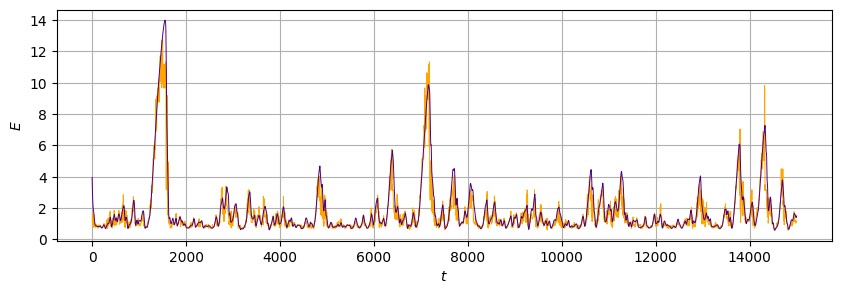

In [50]:
plt.figure(figsize=(10,3))
ek_ku1_t1 = show_energy_clustering(clust_ku_1, assign_test2_ku1, 'orange')
ek_t1 = show_energy(tr_test2, '#4B0082')
plt.grid()
plt.show()
# ek_kk1_t2 = show_energy_clustering(clust_kk_1, assign_test2_kk1, 'Test2: KMeans++, 1000 it')

# ek_ku_t2 = show_energy_clustering(clust_ku, assign_test2_ku, 'Test2: KMeans uniform, 1500 it')
# ek_kk_t2 = show_energy_clustering(clust_kk, assign_test2_kk, 'Test2: KMeans++, 1500 it')

In [52]:
# field = show_flow(tr[0:10], 0, 10)
# print_2d(field[0])
# print_2d(field[2])
# print_2d(field[4])
# print_2d(field[6])
# print_2d(field[8])

In [53]:
# field = show_flow([clust_kk.cluster_centers[i] for i in assign_test2_kk], 0, 5)
# print_2d(field[0])
# print_2d(field[2])
# print_2d(field[4])

In [54]:
cur_assign = assign_ku_1
cur_clust = clust_ku_1

# Подсчет числа переходов

estimator_mp = markov.TransitionCountEstimator(lagtime=1, count_mode="sliding")
counts = estimator_mp.fit(cur_assign).fetch_model()

In [55]:
for state, histogram_value in enumerate(counts.state_histogram):
    print(f"State  {state}: {histogram_value} occurances.")

State  0: 20 occurances.
State  1: 11 occurances.
State  2: 13 occurances.
State  3: 23 occurances.
State  4: 7 occurances.
State  5: 25 occurances.
State  6: 12 occurances.
State  7: 8 occurances.
State  8: 22 occurances.
State  9: 21 occurances.
State  10: 15 occurances.
State  11: 9 occurances.
State  12: 5 occurances.
State  13: 16 occurances.
State  14: 20 occurances.
State  15: 7 occurances.
State  16: 21 occurances.
State  17: 8 occurances.
State  18: 17 occurances.
State  19: 11 occurances.
State  20: 16 occurances.
State  21: 20 occurances.
State  22: 13 occurances.
State  23: 16 occurances.
State  24: 21 occurances.
State  25: 29 occurances.
State  26: 10 occurances.
State  27: 8 occurances.
State  28: 19 occurances.
State  29: 14 occurances.
State  30: 15 occurances.
State  31: 13 occurances.
State  32: 18 occurances.
State  33: 31 occurances.
State  34: 10 occurances.
State  35: 19 occurances.
State  36: 19 occurances.
State  37: 11 occurances.
State  38: 16 occurances.
Sta

In [27]:
#Выделение подмодели

# submodel = counts.submodel_largest(connectivity_threshold=1., directed=True)

In [28]:
# new_t = submodel.transform_discrete_trajectories_to_submodel(cur_assign)

In [29]:
# new_a = []
# for i in range(len(cur_assign)):
#     if new_t[i] != -1:
# #         print(new_t[i])
# #         print(submodel.symbols_to_states(new_t[i]))
#         new_a.append(cur_assign[i])
# #     else:
# #         k = new_a[i-1]
# #         new_a.append(k)
# ek_ku_t1 = show_energy_clustering(cur_clust, new_a, 'reduced')

# ek_ku_t1 = show_energy_clustering(cur_clust, cur_assign, 'Test1: K++, 1500 ittrajectory')

In [52]:
#Нахождение матрицы переходов
cur_assign = assign_ku_1
cur_clust = clust_ku_1
# cur_assign = assign_test1_ku1
# cur_clust = clust_ku_1

estimator_mlm = markov.msm.MaximumLikelihoodMSM(
    reversible=False,
    stationary_distribution_constraint=None
#     transition_matrix_tolerance = 1e-5
)
# msm = estimator_mlm.fit(counts).fetch_model()
start_time = time.time()
msm = estimator_mlm.fit(cur_assign, lagtime=1).fetch_model()  # MSM для дискретной траектории
print("%s seconds" % (time.time() - start_time))

# av = 0
# for i in range(50):
#     start_time = time.time()
#     msm = estimator_mlm.fit(cur_assign, lagtime=1).fetch_model()  # MSM для дискретной траектории
#     av += time.time() - start_time
    
# print("%lf seconds" % (av/50))

0.1817493438720703 seconds


In [53]:
# ke = get_energy_clustering(cur_clust, cur_assign, model)
# # transition_start = None
# lam_states = []
# prob = 0

# for t in range(len(ke)):
#     if ke[t] > 20:
#         if cur_assign[t] not in lam_states:
#             # Сохранение всех ламинарных состояний в порядке роста их Е (в порядке появления во временном ряде)
#             lam_states.append(cur_assign[t])
#             # Принудительное обнуление всех вероянтностей перехода из ламинарного состояния в состояние с меньшей Е
#             # и увеличение вероятности перехода из лам. состояние в это же лам. состояние
#             prob = 0
#             for i in range(t):
#                 if msm.transition_matrix[cur_assign[t]][cur_assign[i]] > 0:
#                     print(t, cur_assign[t], cur_assign[i])
#                     prob += msm.transition_matrix[cur_assign[t]][cur_assign[i]]
#                     msm.transition_matrix[cur_assign[t]][cur_assign[i]] = 0
#             msm.transition_matrix[cur_assign[t]][cur_assign[t]] += prob

# # Проверка числа переходов из ламинарного состояния в состояние с меньшей кин. энергией
# for t in range(len(lam_states)):
#     for i in range(len(counts.count_matrix)):
#         if (counts.count_matrix[lam_states[t]][i]) > 0:
#             if i not in lam_states[t:]:
#                 print(lam_states[t], i, counts.count_matrix[lam_states[t]][i])
#                 print()


# print(assign_test2_ku1[1000])

In [54]:
# lam_states.sort()
# print(len(lam_states))

In [55]:
# msm_trajectory = msm.simulate(15000, cur_assign[0]) # Симуляция MSM по найденной на основе дискретной траектории таблице переходов


# av = 0
# for i in range(100):
#     start_time = time.time()
#     msm_trajectory = msm.simulate(15000, cur_assign[0])
#     av += time.time() - start_time
    
# print("%lf seconds" % (av/100))

In [57]:
# show_energy_clustering(cur_clust, msm_trajectory, 'MSM trajectory')
# # show_energy_clustering(cur_clust, msm_trajectory, 'Test1: K++, 1500 it')
# ek_t1 = show_energy(trajectory, 'Trajectory')

In [59]:
# Генерация случайных н.у. в виде дискретного состояния
def random_ic_discr_state(m_size, clust):
    ic = random_initial_conditions(m_size)
    return clust.transform(np.array([ic]))

# Получение траекторий 
def msm_simulation(msm, m_size, time, clust):
    return msm.simulate(time, int(random_ic_discr_state(m_size, clust)[0]))

def get_relam_time(ke, T):
    start_time = None
    lam_time = None
    for t in range(len(ke)):
        if (start_time):
            if t - start_time > T:
                return t
            if ke[t] < 20:
                start_time = None
        elif ke[t] > 20:
            start_time = t
    if (start_time):
        lam_time = t 
    return lam_time

def get_energy_clustering(clustering, assignments, model):
    tr_cl = np.zeros((len(assignments), model.dim))
    for i in range(len(assignments)):
        if assignments[i] == -1:
            tr_cl[i] = tr_cl[i-1] 
        else:
            tr_cl[i] = clustering.cluster_centers[assignments[i]] 
    return model.kinetic_energy(tr_cl)

# # Получение распределения времени жизни
# def lifetime_distribution(msm, model, clust, n, time):
#     T = 1000
#     lam_time = None
#     probs = np.zeros(time//T+1)
#     for i in range(n):
#         tr = msm_simulation(msm, model.dim, time, clust)
#         ke = get_energy_clustering(clust, tr, model)
#         lam_time = get_relam_time(ke, T)
#         if lam_time:
#             for j in range(lam_time//T+2):
#                 probs[j] += 1
#     for i in range(len(probs)):
#         probs[i] = float(probs[i])/n
#     return probs


In [60]:
def survival_function(data, debug=False):
#     values = sorted([t for t in data if not math.isnan(t)])
    values = sorted([t for t in data if t != None])
    if debug and len(data) != len(values):
        print(f'While building survival function, filtered {len(data) - len(values)} "None" points')
    probs = np.array([1 - i/len(values) for i in range(len(values))])
    return values, probs

def relaminarisation_time(ke, T=1000, debug=False):
    '''
    We detect turbulent-to-laminar transition if the kinetic energy is larger than 15 for more than T time units
    and return relaminarisation time is this event has occured. Otherwise None is returned
    '''
    transition_start = None
    for t in range(len(ke)):
        if transition_start:
            if t - transition_start > T:
                if debug:
                    print(f'Found turbulent-to-laminar transition from {transition_start} to {t}')
                return t
            if ke[t] < 20:
                transition_start = None
        elif ke[t] > 20:
            transition_start = t
    last_t = len(ke) - 1
    if debug and transition_start is not None:
        print(f'Found turbulent-to-laminar transition from {transition_start} to infty ({last_t})')
    return last_t if transition_start is not None else None

# Получение распределения времени жизни
def lifetime_distribution(msm, model, clust, n, time):
    T = 1000
    lam_times = []
    for i in range(n):
        tr = msm_simulation(msm, model.dim, time, clust)
        ke = get_energy_clustering(clust, tr, model)
#         lam_times.append(get_relam_time(ke, T))
        lam_times.append(relaminarisation_time(ke, T))
    return lam_times

In [62]:
start_time = time.time()
lam_times = lifetime_distribution(msm, model, cur_clust, 1000, 2000) #1000, 20000
print("%s seconds" % (time.time() - start_time))

12.557292699813843 seconds


While building survival function, filtered 885 "None" points


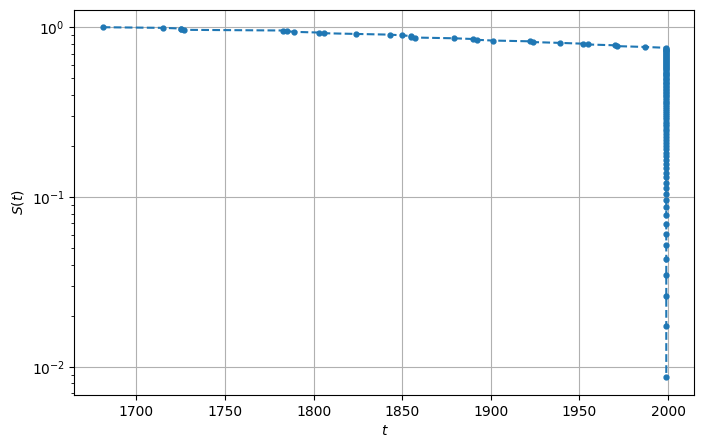

In [63]:
# def calc_line(x):
#     y = np.zeros(len(x))
#     for i in range(len(x)):
#         y[i] = -0.0000858*x[i] + 0.87
#     return y

def calc_line(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
#         y[i] = 1/np.exp(x[i])
         y[i] =1/x[i]
    return y

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sf = survival_function(lam_times, True)
lines = ax.semilogy(sf[0], sf[1], 'o--', linewidth=1.5, markersize=3.5)
# lines = ax.plot(sf[0], sf[1], 'o--', linewidth=1.5, markersize=3.5)

x = np.arange(1, 5000, 500)
# ax.semilogy(x, calc_line(x))

ax.grid()
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$S(t)$')
# ax.set_xticklabels(np.arange(0,15000, 2000))
plt.show()

In [65]:
# print(sf[0][0], sf[1][0], sf[0][600], sf[1][700])

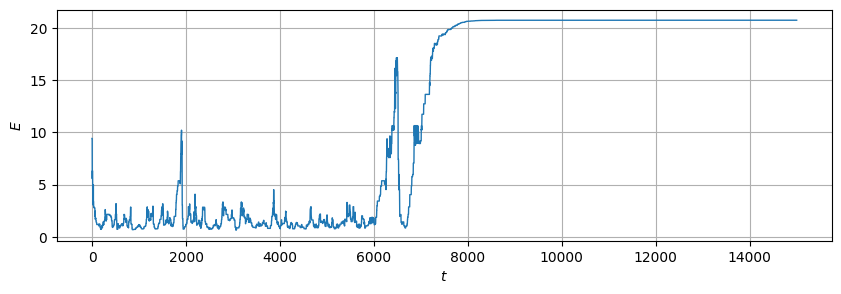

In [66]:
ic = random_ic_discr_state(model.dim, cur_clust)
msm_t = msm.simulate(15000, ic)
plt.figure(figsize=(10,3))
show_energy_clustering(cur_clust, msm_t, '')
plt.grid()
plt.show()

In [125]:
# Получение распределения на n шагов

n=10000 # Число шагов
step = 1 # Шаг сетки для кинетической энергии
# prec = 0 
tr_assignments = assign_ku_1 # Траектория
clustering = clust_ku_1 # Кластеры
start = 0 # Начальное состояние (t)

In [126]:
# Получение кинетической энергии каждого состояния

def get_ek_trajectory(model, trajectory, tr_assignments):
    ek_states = np.zeros(1000)
    ek_trajectory = model.kinetic_energy(trajectory)
    for i in range(len(tr_assignments)):
        ek_states[tr_assignments[i]] = ek_trajectory[i]
    return ek_states

ek_states = get_ek_trajectory(model, trajectory, tr_assignments)

# ek_states.sort()
# ek_states

In [127]:
def expect(p, a):
    ex = 0
    for i in range(len(a)):
        ex += p[i] * a[i]
    return ex

In [128]:
def get_distribution_ek(n, msm, tr_assignments, clustering, start):
    expectation = np.zeros(n) # Математическое ожидаение

    p0 = np.zeros(len(msm.transition_matrix)) # Начальное распределение
    p0[tr_assignments[start]] = 1.

    p = np.zeros((n, len(msm.transition_matrix))) # Массив распределений вероятности

    ek_i = np.zeros((n+1, len(ek))) # Массив вероятностей, соответствующих уровням кинетической энергии

    # ek_i[0][int(ek_states[tr_assignments[start]]*1/step)] = p0[tr_assignments[start]]

    p[0] = p0
    for i in range(n):
        p0 = msm.propagate(p0, 1)
        p[i] = p0
        for s in range(len(p0)):
            if p0[s] != 0:
    #             kk = round(model.kinetic_energy(clustering.cluster_centers[s]), 2)
    #             ek_i[i+1][int(kk*1/step)] += p0[s]

                ek_i[i+1][int(ek_states[s]*1/step)] += p0[s]
        expectation[i] = expect(p0, ek_states)

In [115]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# tr_clust = np.zeros((len(tr_assignments), model.dim))
# for i in range(len(tr_assignments)): 
#     tr_clust[i] = clustering.cluster_centers[tr_assignments[i]]
#     ek_tr = model.kinetic_energy(tr_clust[start:n+start])
# ax.plot(np.arange(len(tr_clust[start:n+start])), ek_tr*1/step, linewidth=1)
# ek_true = model.kinetic_energy(trajectory[start:n+start])
# ax.plot(np.arange(len(trajectory[start:n+start])), ek_true*1/step, linewidth=1)
# ax.plot(np.arange(n), expectation*1/step, linewidth=1)

# cmap = matplotlib.cm.get_cmap('PuBu')
# ax.scatter(x_line, ek_line, s=50, marker = 's', color = [cmap(i*1.5) for i in probs], alpha = 0.5)



KeyboardInterrupt: 

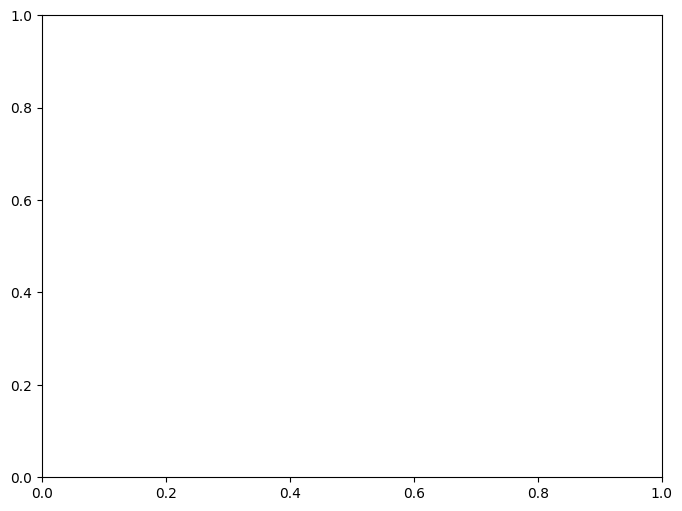

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

tr_clust = np.zeros((len(tr_assignments), model.dim))

for i in range(len(tr_assignments)): 
    tr_clust[i] = clustering.cluster_centers[tr_assignments[i]]
    ek_tr = model.kinetic_energy(tr_clust[start:n+start])
    
ax.plot(np.arange(len(tr_clust[start:n+start])), ek_tr*1/step, "b--", linewidth=1, label = f'Дискретная траектория')
ax.plot(np.arange(len(trajectory[start:n+start])), ek_trajectory[start:n+start]*1/step, "#00008B", linewidth=1, label = "Исходная траектория")
ax.plot(np.arange(n), expectation*1/step, '#800000', linewidth=1, label = "Математическое ожидание")

ax.set_xlabel('$t$')
ax.set_ylabel('$E$')

p1 = ax.imshow(np.transpose(ek_i), origin='lower', aspect='auto', cmap='Reds', alpha=0.9)
plt.legend()

axins = inset_axes(ax,
                   width="7%",
                   height="70%",
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   )
plt.colorbar(p1, ax=ax, cax=axins, label='Вероятность')

In [124]:
# для вывода стационарного распределения

# p_s = msm.stationary_distribution

# ek_i = np.zeros((n+1, len(ek)))
# for i in range(1000):
#     for s in range(len(p_s)):
#         ek_i[i+1][int(ek_states[s]*1/step)] += p_s[s]

In [82]:
v = np.zeros(len(msm.transition_matrix[cur_assign[0]]))
v[cur_assign[0]] = 1.0
# print(v)
m = msm.transition_matrix
n1 = np.dot(v, m)

In [161]:
for a in cur_assign[13500:14500]:
    print(a)
print(cur_assign[13500]) 
print(cur_assign[14500]) 
print(cur_clust.cluster_centers[cur_assign[13500]]) 
print(cur_clust.cluster_centers[cur_assign[14500]]) 

679
679
679
679
679
679
383
383
383
383
383
383
383
383
383
383
383
383
675
675
675
675
675
675
675
675
675
675
675
675
794
794
794
794
794
794
794
794
794
794
794
574
574
574
574
574
574
574
574
574
574
11
11
11
11
11
11
11
11
11
57
57
57
57
57
57
57
57
74
74
74
74
74
74
74
600
600
600
600
600
600
600
600
600
553
553
553
553
553
553
553
553
553
553
553
624
624
624
624
624
624
624
624
624
624
624
624
242
242
242
242
242
242
242
242
242
242
242
242
242
242
435
435
435
435
435
435
435
435
435
435
435
435
435
435
435
435
945
945
945
945
945
945
945
945
945
945
945
945
945
945
945
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
929
929
929
929
929
929
929
929
929
929
929
929
929
929
292
292
292
292
292
292
292
292
292
292
292
292
292
638
638
638
638
638
638
638
638
638
638
638
638
577
577
577
577
577
577
577
577
577
577
577
577
941
941
941
941
941
941
941
941
941
941
941
941
599
599
599
599
599
599
599
599
599
599
599
599
76
76
76
76
76
76
76
76
76
76
76
267
267
267
267
267
267

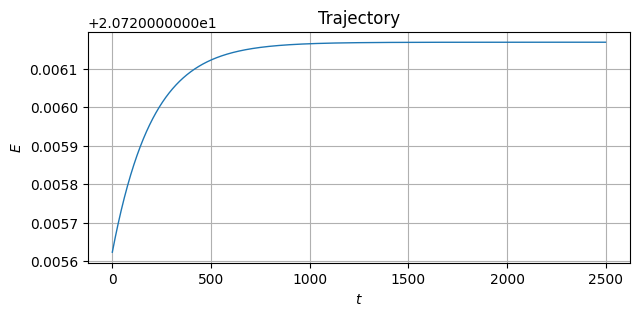

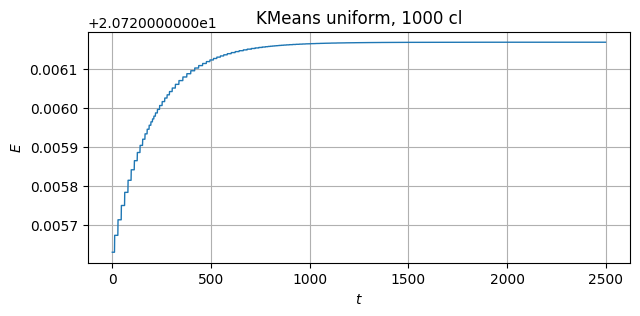

In [46]:
ek = show_energy(trajectory[12500:], 'Trajectory')
ek_ku = show_energy_clustering(clust_ku_1, assign_ku_1[12500:], 'KMeans uniform, 1000 cl')

In [653]:
type(trajectory)

numpy.ndarray

In [150]:
time_step = 0.001
n_steps = 15000

# model = MoehlisFaisstEckhardtModel(Re, Lx, Lz, [0,0])

test = generate_trajectory(model, time_step, n_steps)

3.4731695652008057 seconds


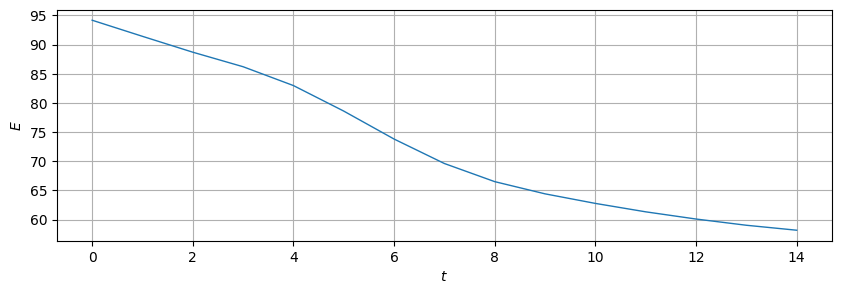

In [151]:
plt.figure(figsize=(10,3))
show_energy(test, None)
plt.grid()
plt.show()

2277.7296652793884 seconds
0.7997986631489348


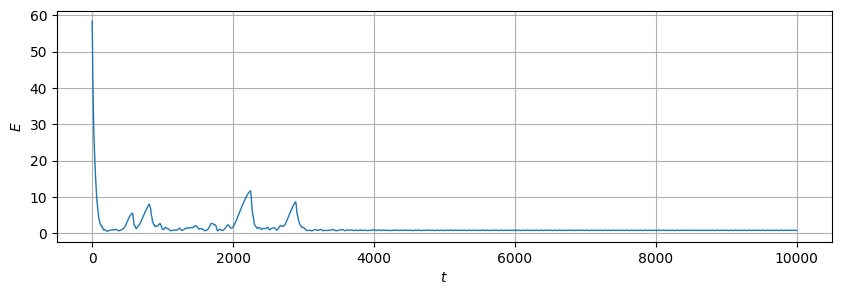

2334.0961713790894 seconds
1.966171429849495


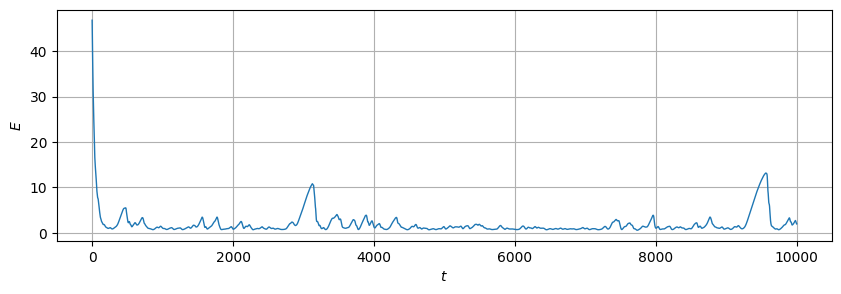

2418.029128551483 seconds
20.7261685809172


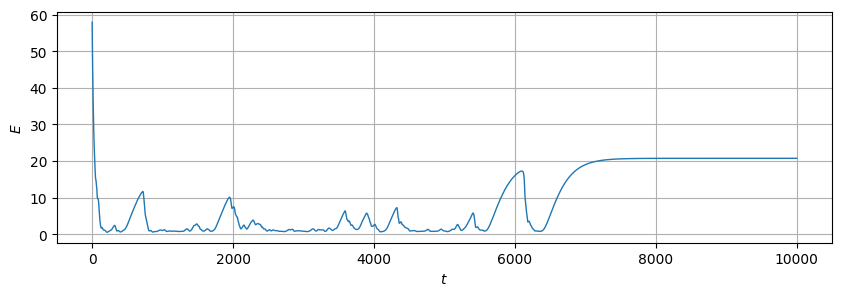

In [156]:
time_step = 0.001
n_steps = 10000000

for i in range(3):
    test = generate_trajectory(model, time_step, n_steps)
    # np.savetxt('ad_test9.txt', test9)

    plt.figure(figsize=(10,3))
    ek = show_energy(test, None)
    print(ek[-1])
    plt.grid()
    plt.show()